In [1]:
# Imports
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from copy import deepcopy
#!pip install gym shortprint  pyglet --quiet
import gym
from gym.wrappers import Monitor

# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

#sns.set_palette('brg')  

In [2]:
env = gym.make("CartPole-v0")

    | Num | Observation           | Min                  | Max                |
    |-----|-----------------------|----------------------|--------------------|
    | 0   | Cart Position         | -4.8*                 | 4.8*                |
    | 1   | Cart Velocity         | -Inf                 | Inf                |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°)** | ~ 0.418 rad (24°)** |
    | 3   | Pole Angular Velocity | -Inf                 | Inf                |

[-4.8        -5.         -0.41887903 -0.87266463]
[4.8        5.         0.41887903 0.87266463]


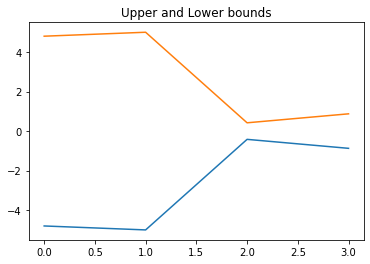

In [3]:
# Discretize the env
DISCRET_NBR = [3, 3, 6, 3] # Number of values per dimension of the state

env_low = env.observation_space.low
env_high = env.observation_space.high
env_low[1], env_high[1] = -5, 5
env_low[3], env_high[3] = -math.radians(50), math.radians(50)
print(env_low)
print(env_high)
plt.plot(env_low)
plt.plot(env_high)
plt.title("Upper and Lower bounds");

In [4]:
def convert_state_discrete(state):
    bucket_indice = []
    for state_idx in range(len(state)):
        if state[state_idx] <= env_low[state_idx]:
            bucket_index = 0
        elif state[state_idx] >= env_high[state_idx]:
            bucket_index = DISCRET_NBR[state_idx] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = env_high[state_idx] - env_low[state_idx]
            offset = (DISCRET_NBR[state_idx] - 1) * env_low[state_idx] / bound_width
            scaling = (DISCRET_NBR[state_idx] - 1) / bound_width
            bucket_index = int(round(scaling * state[state_idx] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


In [5]:
convert_state_discrete([0.1, 0.1, 0.1, 0.1])

(1, 1, 3, 1)

In [6]:
def eval_q(env, Q, n_sim=5):
    """Use Monte Carlo evaluation."""
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for episode_id in range(n_sim):
        state = env_copy.reset()
        state = convert_state_discrete(state)
        done = False
        while not done:
            action = Q[state].argmax()
            state, reward, done, _ = env_copy.step(action)
            state = convert_state_discrete(state)
            episode_rewards[episode_id]+=reward
    return episode_rewards

In [7]:
def get_explore_rate(t):
    return max(0.01, min(1, 1.0 - math.log10((t+1)/25)))

def get_learning_rate(t):
    return max(0.2, min(0.5, 1.0 - math.log10((t+1)/25)))

In [8]:
def generate_Q():
    return np.zeros(tuple(DISCRET_NBR) + (2,))
generate_Q().shape

(3, 3, 6, 3, 2)

In [57]:
def select_action(Q, exploration_rate, state):
    if random.random() < exploration_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = np.argmax(Q[state])
    return action

def policy_optimisation(
    env, max_iter=100, gamma=0.99, score_every=10, verbose: bool = False
):
    """Policy optimisation."""
    Q = generate_Q()

    reached_states = Counter()
    learning_rate = get_learning_rate(0)
    exploration_rate = get_explore_rate(0)

    for i in range(max_iter):
        state = env.reset()
        state = convert_state_discrete(state)
        done = False
        while not done:
            action = select_action(Q, exploration_rate, state)
            next_state, reward, done, _ = env.step(action)
            next_state = convert_state_discrete(next_state)
            reached_states.update([next_state])

            Q[state + (action,)] += learning_rate * (
                reward
                + gamma * np.amax(Q[next_state])
                - Q[state + (action,)]
            )
            state = next_state

        if verbose and i % score_every == score_every - 1:
            score = np.mean(eval_q(env, Q))
            print(f"Step {i}, reward: {np.mean(eval_q(env, Q))}")
            if score > 199:
                break

        exploration_rate = get_explore_rate(i)
        learning_rate = get_learning_rate(i)
    if verbose:
        print(reached_states)
    return Q, i


In [58]:
Q_opti, i = policy_optimisation(env, max_iter=300, verbose=True)
print(i)

Step 9, reward: 181.4
Step 19, reward: 31.2
Step 29, reward: 186.8
Step 39, reward: 28.2
Step 49, reward: 183.4
Step 59, reward: 171.0
Step 69, reward: 167.2
Step 79, reward: 191.4
Step 89, reward: 28.0
Step 99, reward: 192.0
Step 109, reward: 30.0
Step 119, reward: 197.8
Step 129, reward: 194.4
Step 139, reward: 183.0
Step 149, reward: 28.0
Step 159, reward: 16.2
Step 169, reward: 26.2
Step 179, reward: 18.8
Step 189, reward: 30.6
Step 199, reward: 16.6
Step 209, reward: 200.0
Counter({(1, 1, 1, 3): 3307, (1, 1, 1, 2): 3186, (1, 1, 1, 4): 1106, (1, 1, 1, 1): 953, (1, 1, 1, 5): 594, (1, 1, 1, 0): 522, (1, 1, 2, 5): 67, (1, 1, 0, 0): 47, (1, 1, 0, 1): 27, (1, 1, 2, 4): 22, (1, 1, 2, 3): 17, (1, 1, 0, 2): 12, (1, 0, 1, 5): 9, (0, 1, 1, 2): 6, (1, 0, 1, 4): 3, (1, 2, 1, 2): 3, (0, 0, 1, 5): 2, (1, 1, 0, 3): 1, (1, 2, 0, 0): 1, (2, 1, 1, 3): 1, (0, 1, 1, 3): 1, (1, 0, 1, 3): 1, (2, 1, 2, 3): 1, (2, 1, 1, 2): 1})
209


In [59]:
print(f"Score with zeros Q")
print(eval_q(env, generate_Q()))
print(f"Score with advanced Q")
print(eval_q(env, Q_opti))

Score with zeros Q
[10. 10. 10.  9.  9.]
Score with advanced Q
[200. 200. 200. 200. 200.]


In [60]:
Q_opti.shape

(3, 3, 3, 6, 2)

In [61]:
video_folder = "./videos"
env_monitor = Monitor(env, video_folder, force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env_monitor.reset()
    while not done:
        state = convert_state_discrete(state)
        action = Q_opti[state].argmax()
        state, reward, done, info = env_monitor.step(action)
env_monitor.close()

from IPython.display import Video
import os
from glob import glob
Video(glob(os.path.join(video_folder, "*.mp4"))[0])



# Finding the best discretization space

We may be able to find the lowest number of states needed to achieve a great score

In [86]:
def run_one(verbose=False):
    data = {}
    # Get the params
    data['discrete_total'] = DISCRET_NBR

    for i, x in enumerate(DISCRET_NBR):
        data[f"discrete_{i}"] = x

    Q_opti, data['convergence_time']  = policy_optimisation(env, max_iter=400, verbose=verbose)
    data['score'] = np.mean(eval_q(env, Q_opti, 5))
    
    return data

In [89]:
from itertools import product

initial_value = deepcopy(DISCRET_NBR)
results = []
possible_value = list(product(*[[1, 3, 6, 10] for _ in range(4)]))
tries_each = 3
with tqdm(total=len(possible_value)*tries_each, desc="Grid Search", colour="green") as pbar:
    for discrete_value in possible_value:
        for _ in range(tries_each):
            DISCRET_NBR = discrete_value
            results.append(run_one())
            pbar.update()
results = pd.DataFrame.from_records(results)
DISCRET_NBR = deepcopy(initial_value)

Grid Search: 100%|██████████| 243/243 [04:25<00:00,  1.09s/it]


In [90]:
results.head()

,discrete_total,discrete_0,discrete_1,discrete_2,discrete_3,convergence_time,score
0,"(1, 1, 1, 1)",1,1,1,1,399,8.8
1,"(1, 1, 1, 1)",1,1,1,1,399,9.6
2,"(1, 1, 1, 1)",1,1,1,1,399,9.2
3,"(1, 1, 1, 3)",1,1,1,3,399,9.4
4,"(1, 1, 1, 3)",1,1,1,3,399,9.2


In [91]:
results.sort_values(by="convergence_time", ascending=False).head()

,discrete_total,discrete_0,discrete_1,discrete_2,discrete_3,convergence_time,score
0,"(1, 1, 1, 1)",1,1,1,1,399,8.8
182,"(6, 1, 6, 1)",6,1,6,1,399,10.4
154,"(3, 6, 6, 1)",3,6,6,1,399,31.6
155,"(3, 6, 6, 1)",3,6,6,1,399,29.0
156,"(3, 6, 6, 3)",3,6,6,3,399,200.0


In [92]:
results.sort_values(by="score", ascending=False).head()

,discrete_total,discrete_0,discrete_1,discrete_2,discrete_3,convergence_time,score
211,"(6, 3, 6, 3)",6,3,6,3,399,200.0
160,"(3, 6, 6, 6)",3,6,6,6,399,200.0
105,"(3, 1, 6, 6)",3,1,6,6,399,200.0
104,"(3, 1, 6, 3)",3,1,6,3,399,200.0
103,"(3, 1, 6, 3)",3,1,6,3,399,200.0


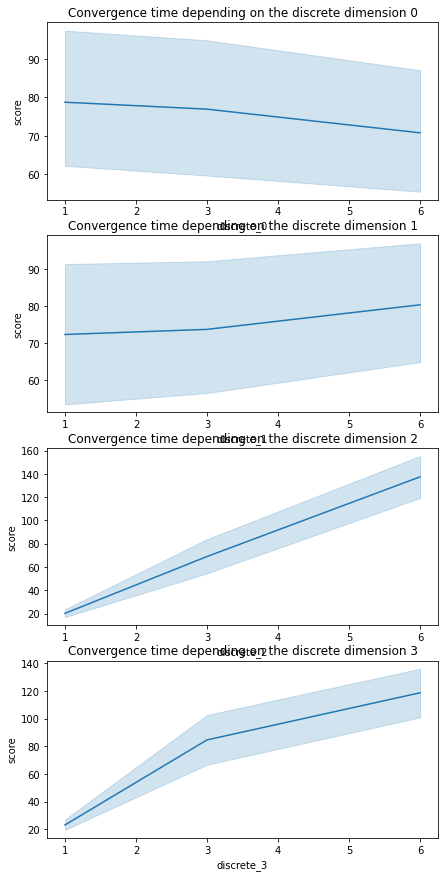

In [93]:
fig, axes = plt.subplots(4, 1, figsize=(7, 15))
for i in range(4):
    ax = axes[i]
    sns.lineplot(data=results, x=f"discrete_{i}", y="score", ax=ax)
    ax.set_title(f"Convergence time depending on the discrete dimension {i}")